In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
mvc = pd.read_csv("nypd_mvc_2018.csv")

In [29]:
print(mvc)

unique_key        date   time    borough                location  \
0         3869058  2018-03-23  21:40  MANHATTAN  (40.742832, -74.00771)   
1         3847947  2018-02-13  14:45   BROOKLYN  (40.623714, -73.99314)   
2         3914294  2018-06-04   0:00        NaN   (40.591755, -73.9083)   
3         3915069  2018-06-05   6:36     QUEENS   (40.73602, -73.87954)   
4         3923123  2018-06-16  15:45      BRONX  (40.884727, -73.89945)   
...           ...         ...    ...        ...                     ...   
57859     3835191  2018-01-26  14:51      BRONX   (40.85477, -73.90299)   
57860     3890674  2018-04-29  18:30     QUEENS   (40.78419, -73.84582)   
57861     3946458  2018-07-21  16:45        NaN   (40.711926, -74.0061)   
57862     3914574  2018-06-04   5:45        NaN   (40.71976, -73.94476)   
57863     4034882  2018-11-29   8:26        NaN  (40.69181, -73.988235)   

                              on_street     cross_street  \
0      WEST 15 STREET                         

In [30]:
#summary of the columns and their data is below:

# unique_key: A unique identifier for each collision.
# date, time: Date and time of the collision.
# borough: The borough, or area of New York City, where the collision occurred.
# location: Latitude and longitude coordinates for the collision.
# on_street, cross_street, off_street: Details of the street or intersection where the collision occurred.
# pedestrians_injured: Number of pedestrians who were injured.
# cyclist_injured: Number of people traveling on a bicycle who were injured.
# motorist_injured: Number of people traveling in a vehicle who were injured.
# total_injured: Total number of people injured.
# pedestrians_killed: Number of pedestrians who were killed.
# cyclist_killed: Number of people traveling on a bicycle who were killed.
# motorist_killed: Number of people traveling in a vehicle who were killed.
# total_killed: Total number of people killed.
# vehicle_1 through vehicle_5: Type of each vehicle involved in the accident.
# cause_vehicle_1 through cause_vehicle_5: Contributing factor for each vehicle in the accident.

In [31]:
#Counting missing vals recap
data = np.random.choice([1.0, np.nan],
                        size=(3, 3),
                        p=[.3, .7])
df = pd.DataFrame(data, columns=['A','B','C'])
print(df)   #plain df
print(df.isnull()) #show null values
print(df.isnull().sum()) #Show sum of null vals

A   B    C
0 NaN NaN  1.0
1 NaN NaN  NaN
2 NaN NaN  1.0
      A     B      C
0  True  True  False
1  True  True   True
2  True  True  False
A    3
B    3
C    1
dtype: int64


In [32]:
#Find null counts in mvc df
null_counts = mvc.isnull().sum()

In [33]:
#PCT of null vals in each column
null_counts_pct = null_counts / mvc.shape[0] * 100
null_df = pd.DataFrame({'null_counts': null_counts, 'null_pct': null_counts_pct})
# Rotate the dataframe so that rows become columns and vice-versa
null_df = null_df.T.astype(int)
#print(null_df)


In [34]:
#Verifying total Columns
killed_cols = [col for col in mvc.columns if 'killed' in col]
killed = mvc[killed_cols].copy()

killed_manual_sum = killed.iloc[:,:3].sum(axis=1)

killed_mask = killed_manual_sum != killed['total_killed']
killed_non_eq = killed[killed_mask]
killed_non_eq

,pedestrians_killed,cyclist_killed,motorist_killed,total_killed
3508,0,0,0,NaN
20163,0,0,0,NaN
22046,0,0,1,0.0
48719,0,0,0,NaN
55148,0,0,0,NaN
55699,0,0,0,NaN


In [35]:
#Fixing and verifying killed/injured data

#USEFUL METHOD: Series.mask(bool_mask, val_to_replace)

# fix the killed values
killed['total_killed'] = killed['total_killed'].mask(killed['total_killed'].isnull(), killed_manual_sum)
killed['total_killed'] = killed['total_killed'].mask(killed['total_killed'] != killed_manual_sum, np.nan)

# Create an injured dataframe and manually sum values
injured = mvc[[col for col in mvc.columns if 'injured' in col]].copy()
injured_manual_sum = injured.iloc[:,:3].sum(axis=1)
injured['total_injured'] = injured['total_injured'].mask(injured['total_injured'].isnull(), injured_manual_sum)
injured['total_injured'] = injured['total_injured'].mask(injured['total_injured'] != injured_manual_sum, np.nan)

In [36]:
#Summarizing count of nulls before and after:
summary = {
    'injured': [
        mvc['total_injured'].isnull().sum(),
        injured['total_injured'].isnull().sum()
    ],
    'killed': [
        mvc['total_killed'].isnull().sum(),
        killed['total_killed'].isnull().sum()
    ]
}
print(pd.DataFrame(summary, index=['before','after']))


injured  killed
before        1       5
after        21       1


In [37]:
#Assigning values from killed & injured back to original df
mvc['total_injured'] = injured['total_injured']
mvc['total_killed'] = killed['total_killed']
                             

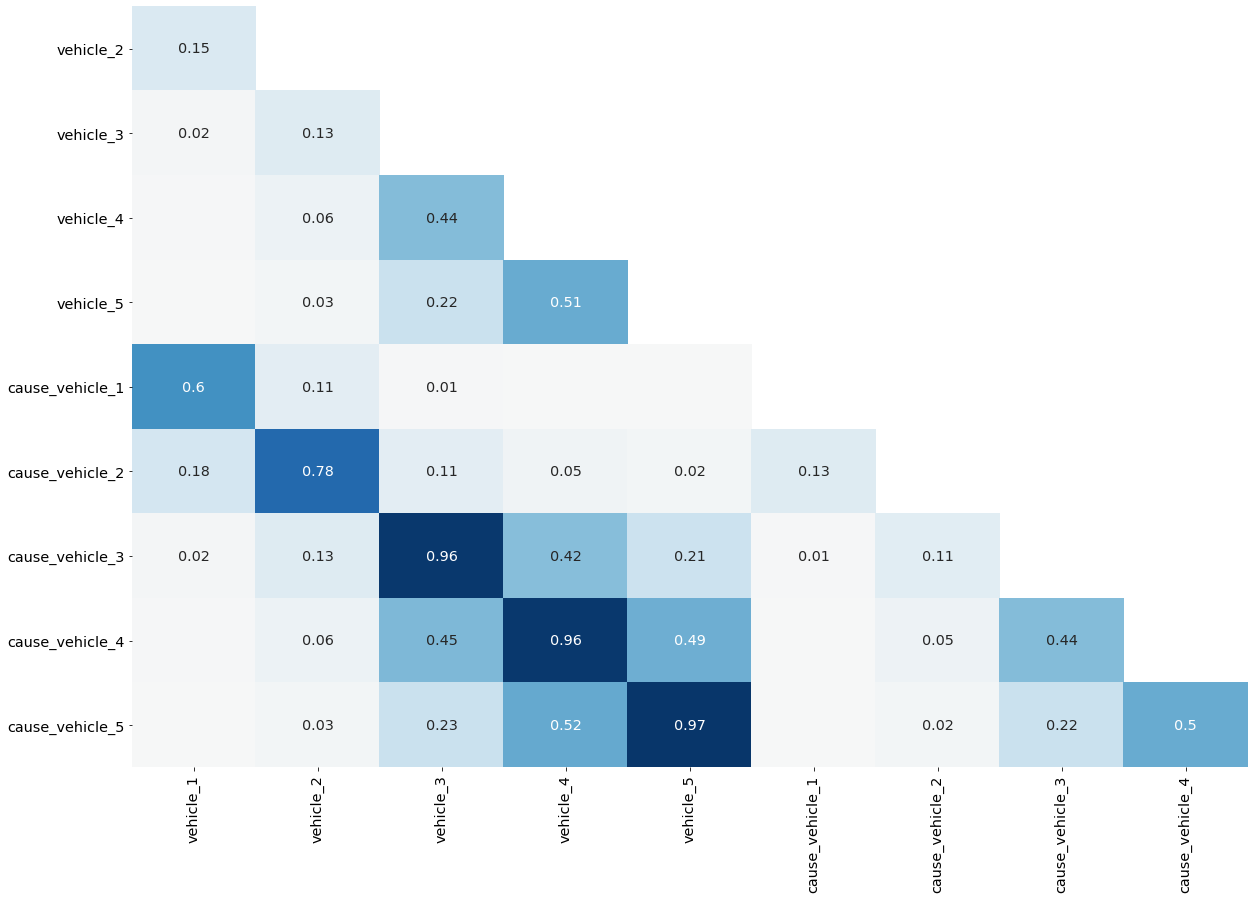

In [38]:
#Visualizing missing data with plots

def plot_null_correlations(df):
    # create a correlation matrix only for columns with at least
    # one missing value
    cols_with_missing_vals = df.columns[df.isnull().sum() > 0]
    missing_corr = df[cols_with_missing_vals].isnull().corr()
    
    # create a mask to avoid repeated values and make
    # the plot easier to read
    missing_corr = missing_corr.iloc[1:, :-1]
    mask = np.triu(np.ones_like(missing_corr), k=1)
    
    # plot a heatmap of the values
    plt.figure(figsize=(20,14))
    ax = sns.heatmap(missing_corr, vmin=-1, vmax=1, cbar=False,
                     cmap='RdBu', mask=mask, annot=True)
    
    # format the text in the plot to make it easier to read
    for text in ax.texts:
        t = float(text.get_text())
        if -0.05 < t < 0.01:
            text.set_text('')
        else:
            text.set_text(round(t, 2))
        text.set_fontsize('x-large')
    plt.xticks(rotation=90, size='x-large')
    plt.yticks(rotation=0, size='x-large')

    plt.show()
    
    

vehicle_cols = [x for x in mvc.columns if 'vehicle' in x]
plot_null_correlations(mvc[vehicle_cols])

In [39]:
#Analyzing COrrelations in missing Data
col_labels = ['v_number', 'vehicle_missing', 'cause_missing']

vc_null_data = []

for v in range(1,6):
    v_col = 'vehicle_{}'.format(v)
    c_col = 'cause_vehicle_{}'.format(v)
    
    v_null = (mvc[v_col].isnull() & mvc[c_col].notnull()).sum()
    c_null = (mvc[c_col].isnull() & mvc[v_col].notnull()).sum()
    
    vc_null_data.append([v, v_null, c_null])
    
vc_null_df = pd.DataFrame(vc_null_data, columns =col_labels)
vc_null_df

,v_number,vehicle_missing,cause_missing
0,1,204,24
1,2,3793,223
2,3,242,24
3,4,50,3
4,5,10,0


In [40]:
#Finding most common values accross multiple columns using DataFrame.stack()

v_cols = [c for c in mvc.columns if c.startswith("vehicle")]

df = mvc[v_cols]
stack = df.stack()
vehicle_counts = stack.value_counts()

top10_vehicles = vehicle_counts.head(10)


In [41]:

#Func to loop through values and label missing columns with boolean mask
def summarize_missing():
    v_missing_data = []

    for v in range(1,6):
        v_col = 'vehicle_{}'.format(v)
        c_col = 'cause_vehicle_{}'.format(v)

        #Filter based off if v_col is null, or c_col is null
        v_missing = (mvc[v_col].isnull() & mvc[c_col].notnull()).sum()
        c_missing = (mvc[c_col].isnull() & mvc[v_col].notnull()).sum()

        v_missing_data.append([v, v_missing, c_missing])

    col_labels = columns=["vehicle_number", "vehicle_missing", "cause_missing"]
    return pd.DataFrame(v_missing_data, columns=col_labels)

summary_before = summarize_missing()

#Create boolean mask for vals where v_col null and cause col is nonnull
#Bool mask for vals where c_col null and v_col nonnull
#Use first mask to fill matching vals in v_col with 'unspecified', then do the same for c_col with the 2nd mask
#Check data after loop to ensure its changed
for v in range(1,6):
    v_col = 'vehicle_{}'.format(v)
    c_col = 'cause_vehicle_{}'.format(v)
    
    v_missing_mask = (mvc[v_col].isnull() & mvc[c_col].notnull())
    c_missing_mask = (mvc[v_col].notnull() & mvc[c_col].isnull())
    
    mvc[v_col] = mvc[v_col].mask(v_missing_mask, "Unspecified")
    mvc[c_col] = mvc[c_col].mask(c_missing_mask, 'Unspecified')
    
summary_after = summarize_missing()

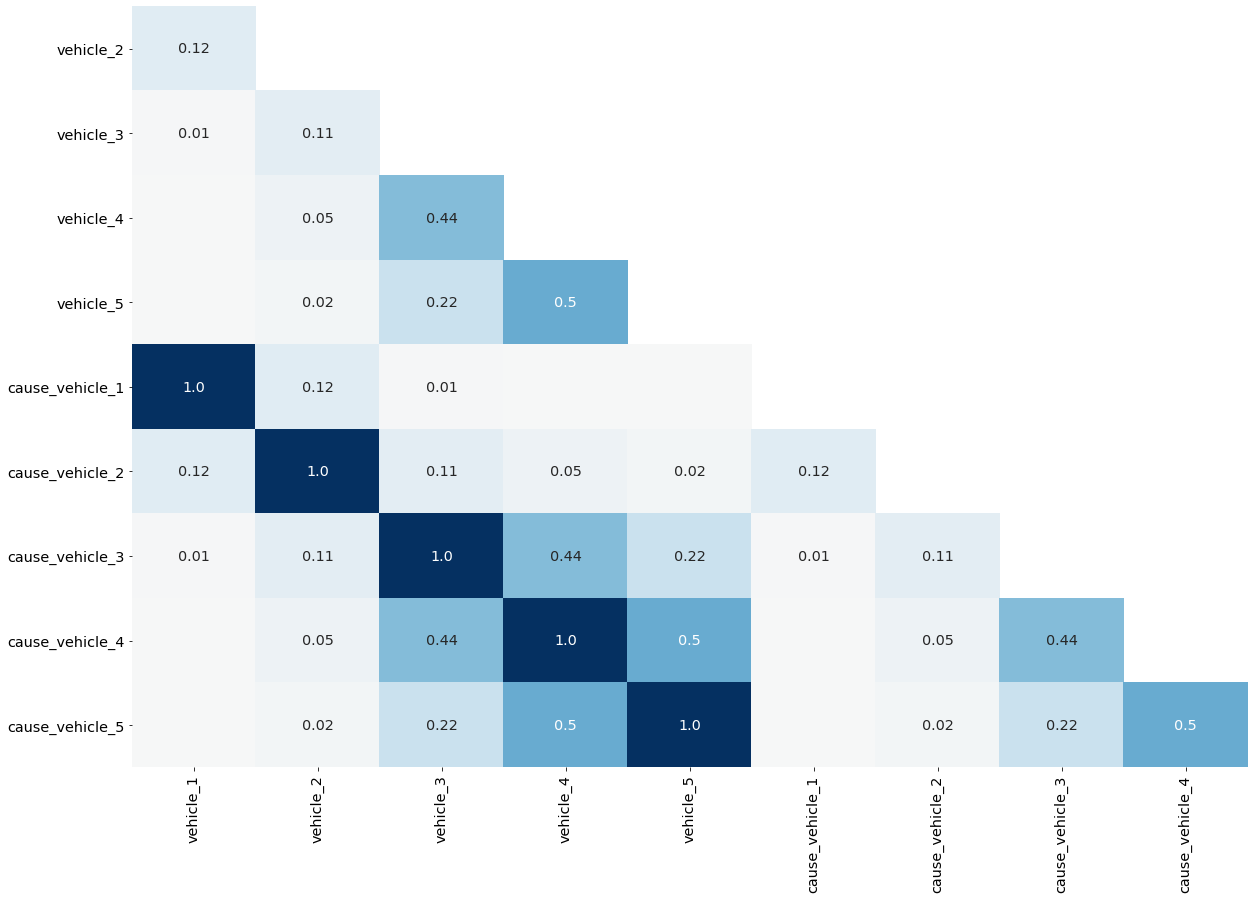

In [42]:
#Viewing work done so far
veh_cols = [c for c in mvc.columns if 'vehicle' in c]
plot_null_correlations(mvc[veh_cols])

In [43]:
#looking at final set of cols that contain missing vals, relate to location of accident
loc_cols = ['borough', 'location', 'on_street', 'off_street', 'cross_street']
location_data = mvc[loc_cols]
print(location_data.head())
print(location_data.isnull().sum())

borough                location                         on_street  \
0  MANHATTAN  (40.742832, -74.00771)  WEST 15 STREET                     
1   BROOKLYN  (40.623714, -73.99314)  16 AVENUE                          
2        NaN   (40.591755, -73.9083)  BELT PARKWAY                       
3     QUEENS   (40.73602, -73.87954)  GRAND AVENUE                       
4      BRONX  (40.884727, -73.89945)                               NaN   

                                 off_street    cross_street  
0                                       NaN       10 AVENUE  
1                                       NaN       62 STREET  
2                                       NaN             NaN  
3                                       NaN  VANLOON STREET  
4  208       WEST 238 STREET                            NaN  
borough         20646
location         3885
on_street       13961
off_street      44093
cross_street    29249
dtype: int64


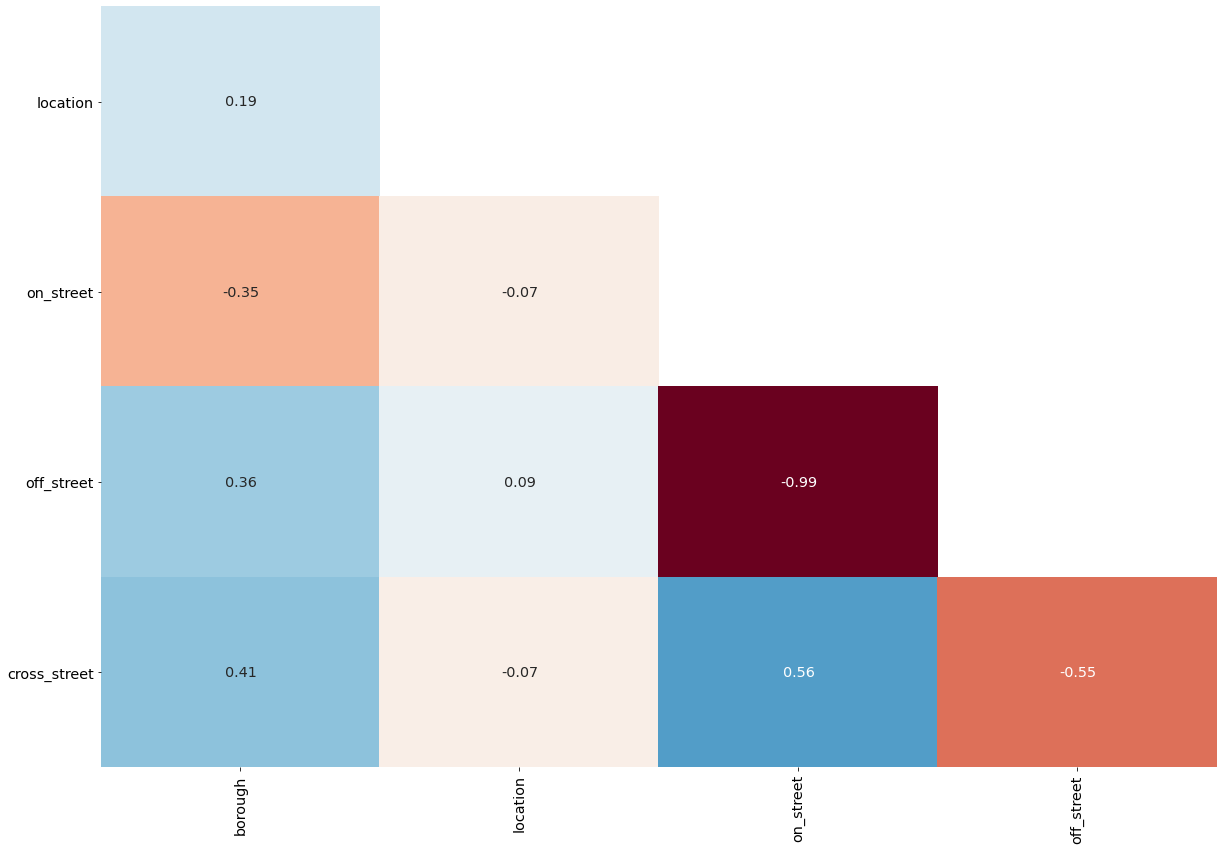

In [44]:
#To check if non-null vals can be used to impute some null values, use correlations
plot_null_correlations(location_data)

In [45]:
#Generate a null matrix, sort data first to make patterns more obvious
#sorted_location_data = location_data.sort_values(loc_cols)
#plot_null_matrix(sorted_location_data)

In [46]:
#Using supplemental data csv now. Imputing Location Data
sup_data = pd.read_csv('supplemental_data.csv')

location_cols = ['location', 'on_street', 'off_street', 'borough']
null_before = mvc[location_cols].isnull().sum()

for c in location_cols:
    #if mvc[c] is null, replace with corresponding sup data from sup_data[c]
    mvc[c] = mvc[c].mask(mvc[c].isnull(), sup_data[c])
    
#check null vals after
null_after = mvc[location_cols].isnull().sum()

In [47]:
#Potential ideas to continue with data
# Drop the rows that had suspect values for injured and killed totals.
# Clean the values in the vehicle_1 through vehicle_5 columns by analyzing the different values and merging duplicates and near-duplicates.
# Analyze whether collisions are more likely in certain locations, at certain times, or for certain vehicle types.
